In [35]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use("ggplot")
import tensorflow as tf
from crf.comlid_crf import *
from helper.dataset_reader import read_tsv

In [36]:
from tensorflow.python.client import device_lib

print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.8.0
GPU detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [37]:
langid = LanguageIdentifier()

In [38]:
data = read_tsv('../dataset/comlid-data-140422-v1.tsv')

In [39]:
all_data, words, tags = data

In [40]:
# create list of tuples from all words and all tags
word_tag = list(zip(words, tags))
# print(word_tag)
# convert list to dataframe
df_wordtag = pd.DataFrame(word_tag, columns=['Token','Label'])
# df_wordtag

In [41]:
words = list(set(df_wordtag['Token'].values))
words.append("ENDPAD")
num_words = len(words)
# print(num_words)

In [42]:
tags = list(set(df_wordtag["Label"].values))
num_tags = len(tags)
# print(num_tags)

In [43]:
dt_pair = langid.data_transformer(data)
# dt_pair[0]

In [44]:
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

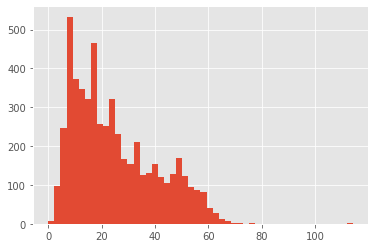

In [45]:
plt.hist([len(s) for s in dt_pair], bins=50)
plt.show()

In [46]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = 50

X = [[word2idx[w[0]] for w in s] for s in dt_pair]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=num_words-1)

y = [[tag2idx[w[1]] for w in s] for s in dt_pair]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

In [47]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

In [48]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, Flatten
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [49]:
input_word = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=50, input_length=max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags, activation="softmax"))(model)
model = Model(input_word, out)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 50, 50)            1344500   
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 50, 50)           0         
 lDropout1D)                                                     
                                                                 
 bidirectional_1 (Bidirectio  (None, 50, 200)          120800    
 nal)                                                            
                                                                 
 time_distributed_1 (TimeDis  (None, 50, 7)            1407      
 tributed)                                                       
                                                           

In [50]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [51]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

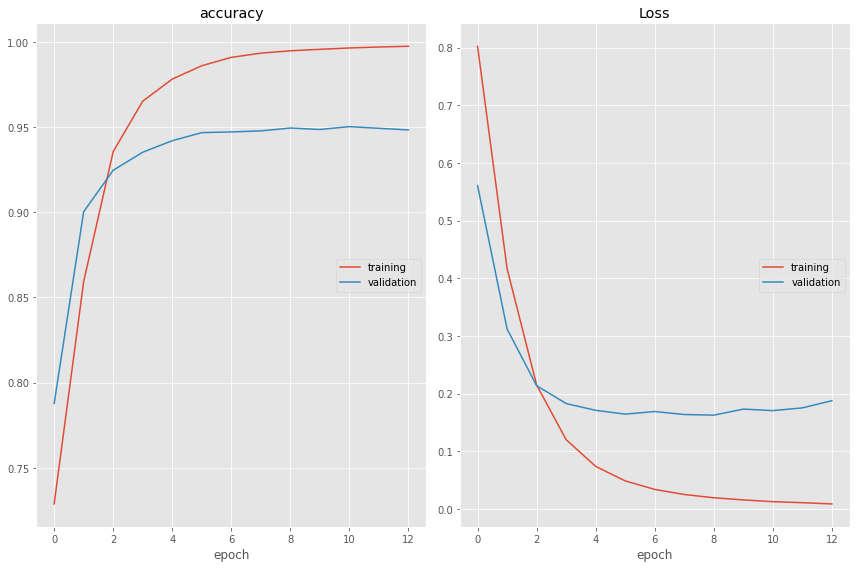

accuracy
	training         	 (min:    0.729, max:    0.998, cur:    0.998)
	validation       	 (min:    0.788, max:    0.950, cur:    0.948)
Loss
	training         	 (min:    0.009, max:    0.802, cur:    0.009)
	validation       	 (min:    0.163, max:    0.561, cur:    0.188)

Epoch 13: val_loss did not improve from 0.16283
113/113 [==============================] - 41s 362ms/step - loss: 0.0089 - accuracy: 0.9975 - val_loss: 0.1878 - val_accuracy: 0.9484
CPU times: total: 16min 26s
Wall time: 8min 49s


In [52]:
%%time

chkpt = ModelCheckpoint("../model/model_weights.h5", monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=True, mode='min')

early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=2, verbose=0, mode='max', baseline=None, restore_best_weights=False)

callbacks = [PlotLossesCallback(), chkpt, early_stopping]

history = model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_test,y_test),
    batch_size=32,
    epochs=50,
    callbacks=callbacks,
    verbose=1
)

In [53]:
model.evaluate(x_test, y_test)

56/56 [==============================] - 2s 43ms/step - loss: 0.1878 - accuracy: 0.9484


[0.18784692883491516, 0.9483997821807861]

In [54]:
idx2tag = {i: w for w,i in tag2idx.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        for p in pred_i:
            p_i = np.argmax(p)
            out.append(idx2tag[p_i].replace("ENDPAD", "O"))

    return out

def test2label(y_test):
    tags = []
    for val in y_test:
        for v in val:
            tags.append(idx2tag[v])

    return tags

y_test_pred = test2label(y_test)

In [55]:
y_pred = model.predict(x_test, verbose=1)
y_pred = pred2label(y_pred)

56/56 [==============================] - 3s 44ms/step


In [56]:
from sklearn.metrics import classification_report, confusion_matrix

labels = ['ID', 'JV', 'EN', 'MIX-ID-EN', 'MIX-ID-JV', 'MIX-JV-EN', 'O']

print(classification_report(y_test_pred, y_pred, labels=labels))

              precision    recall  f1-score   support

          ID       0.88      0.97      0.92     21495
          JV       0.86      0.83      0.85      4734
          EN       0.91      0.85      0.88      5202
   MIX-ID-EN       0.97      0.82      0.89       996
   MIX-ID-JV       0.82      0.75      0.78       318
   MIX-JV-EN       0.95      0.81      0.88       238
           O       0.99      0.96      0.98     56067

    accuracy                           0.95     89050
   macro avg       0.91      0.86      0.88     89050
weighted avg       0.95      0.95      0.95     89050



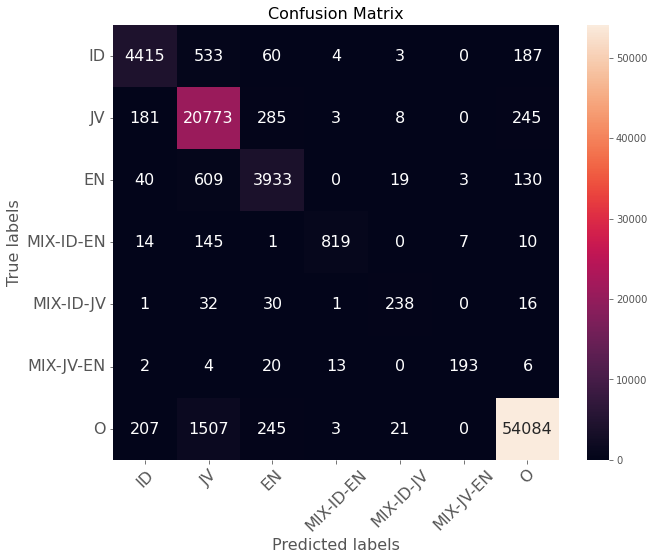

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_pred, y_pred)
# sns.heatmap(cm, annot=True, fmt='d', ax=ax)
fig, ax = plt.subplots(figsize=(10,8))

# plt.figure(figsize=(12, 10))
# sns.set(rc={'figure.figsize': (14, 12)})
sns.heatmap(cm, annot=True, fmt='d', ax=ax, annot_kws={'size': 16})
# annot=True to annotate cells, ftm='g' to disable scientific notation


# labels, title and ticks
ax.set_title('Confusion Matrix', fontsize=16)
ax.set_xlabel('Predicted labels', fontsize=16)
ax.set_ylabel('True labels', fontsize=16)
ax.xaxis.set_ticklabels(labels, rotation=45, fontsize=16)
ax.yaxis.set_ticklabels(labels, rotation=0, fontsize=16)

plt.show()

In [58]:
i = np.random.randint(0, x_test.shape[0]) #659
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)
y_true = y_test[i]
print("{:30}{:10}\t {}\n".format("Word", "True", "Pred"))
print("-" *60)
for w, true, pred in zip(x_test[i], y_true, p[0]):
    print("{:30}{:10}\t{}".format(words[w-1], tags[true], tags[pred]))

Word                          True      	 Pred

------------------------------------------------------------
alhamdulillah                 ID        	ID
ya                            ID        	ID
Allah                         O         	O
rezeki                        ID        	ID
dibulan                       ID        	ID
ramadhan                      O         	O
,                             O         	O
terima                        ID        	ID
kasih                         ID        	ID
banyak                        ID        	ID
buat                          ID        	ID
@christaline_                 O         	ID
dan                           ID        	ID
sponsor                       ID        	ID
@AFTERDEATH_NFT               O         	ID
dan                           ID        	ID
ga                            ID        	ID
lupa                          ID        	ID
juga                          ID        	ID
admin                         ID        	ID
@christagifts_